In [1]:
import numpy as np
import pickle

from gpu import set_gpu
from matplotlib import pyplot as plt
import loop as lp
set_gpu()

Num GPUs Available:  1


In [2]:
sub_type = 'TR'
with open('train_data_raw_'  + sub_type + '.p', 'rb') as f:
    raw, params,feat,feat_sq = pickle.load(f)

In [5]:
old_acc = last_acc
old_val = last_val

In [14]:
last_acc = np.full([1,4],np.nan)
last_val = np.full([1,4],np.nan)
i = 0

temp_acc, temp_val, file_name = lp.loop_cv(raw, params, sub_type, load=False, n_train='fullgaussflat4', train_scale=5,epochs=100, batch_size = 128, sparsity=True,dt='cv',feat_type='feat',noise=True, latent_dim=10,sub=1,dense=False)
last_acc[i,:] = np.nanmean(temp_acc,axis=0)
last_val[i,:] = np.nanmean(temp_val,axis=0)
i += 1

Running sub 1, model 2, latent dim 10, cv 1
['loss', 'decoder_loss', 'clf_loss', 'encoder_loss', 'decoder_accuracy', 'clf_accuracy', 'encoder_accuracy']
[6.39866543 0.02515587 1.7419467  4.62560701 0.00911458 0.3359375
 0.109375   5.97404528 0.08753667 1.684389   4.19633007 0.01083333
 0.34269843 0.09047619]
['loss', 'decoder_loss', 'clf_loss', 'encoder_loss', 'decoder_accuracy', 'clf_accuracy', 'encoder_accuracy']
[8.12932816e+01 5.51562428e-01 1.93987679e+00 7.87995453e+01
 9.11458302e-03 1.95312500e-01 7.03125000e-02 3.27320385e+00
 2.49999110e-02 1.89020491e+00 1.35562623e+00 1.08333332e-02
 2.08730161e-01 1.00158729e-01]
['loss', 'decoder_loss', 'clf_loss', 'encoder_loss', 'decoder_accuracy', 'clf_accuracy', 'encoder_accuracy']
[5.51699972 0.02221752 1.85057139 3.64217877 0.00911458 0.203125
 0.1015625  3.51547766 0.01386249 1.79227316 1.7075479  0.01083333
 0.25492063 0.10793651]
['loss', 'decoder_loss', 'clf_loss', 'encoder_loss', 'decoder_accuracy', 'clf_accuracy', 'encoder_acc

KeyboardInterrupt: 

In [3]:
# Loop through noise
acc_all, acc_noise, acc_clean, file_name = lp.loop_noise(raw, params, sub_type, load=False, n_train='fullgaussflat4', train_scale=5, n_test=0,epochs=30, batch_size = 128, sparsity=True,dt='cv',feat_type='feat',noise=True, latent_dim=4)

10 - clf_loss: 0.7969 - decoder_accuracy: 0.0039 - clf_accuracy: 0.6803 - val_loss: 1.0422 - val_decoder_loss: 0.0800 - val_clf_loss: 0.9572 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6190
Epoch 11/30
18900/18900 [==============================] - 2s 126us/sample - loss: 0.8524 - decoder_loss: 0.0848 - clf_loss: 0.7650 - decoder_accuracy: 0.0039 - clf_accuracy: 0.6941 - val_loss: 1.0159 - val_decoder_loss: 0.0789 - val_clf_loss: 0.9367 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6186
Epoch 12/30
18900/18900 [==============================] - 2s 115us/sample - loss: 0.8229 - decoder_loss: 0.0882 - clf_loss: 0.7323 - decoder_accuracy: 0.0039 - clf_accuracy: 0.7081 - val_loss: 0.9926 - val_decoder_loss: 0.0857 - val_clf_loss: 0.9000 - val_decoder_accuracy: 0.0020 - val_clf_accuracy: 0.6271
Epoch 13/30
18900/18900 [==============================] - 2s 114us/sample - loss: 0.8014 - decoder_loss: 0.0913 - clf_loss: 0.7074 - decoder_accuracy: 0.0039 - clf_accuracy: 0.7258 -

In [5]:
vcnn_hist['accuracy'][-1]

0.7937566

In [4]:
sub_all = acc_all[0,...]
sub_clean = acc_clean[0,...]
sub_noise = acc_noise[0,...]

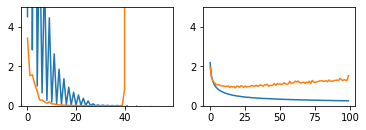

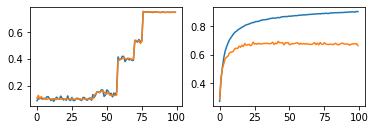

In [18]:
train_grp = 2
dt = 'cv'
feat_type = 'feat'
latent_dim = 10
epochs = 100
n_train = 'fullgaussflat4'
train_scale = 5
foldername = 'models' + '_' + str(train_grp) + '_' + dt
batch_size = 128
n_test = 0
lr = 0.001
den = False

loss = np.zeros((4,2,epochs))
val_loss = np.zeros((4,2,epochs))
acc = np.zeros((4,2,epochs))
val_acc = np.zeros((4,2,epochs))

for sub in range(1,2):#6):
    for cv in range(1,5):
        filename = foldername + '/' + sub_type + str(sub) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_bat_' + str(batch_size) + '_' + n_train + '_' + str(train_scale) + '_lr_' + str(int(lr*10000)) 
        if not den:
            filename += '_den_'
        filename += '_cv_'+ str(cv) + '_sparse'
        with open(filename + '_hist.p', 'rb') as f:
            svae_hist, sae_hist, cnn_hist, vcnn_hist = pickle.load(f)
        svae_hist = np.transpose(svae_hist)
        loss[cv-1,...] = np.array([svae_hist[3,:], sae_hist['loss']])#, cnn_hist['loss'], vcnn_hist['loss']])
        val_loss[cv-1,...] = np.array([svae_hist[10,:], sae_hist['val_loss']])#, cnn_hist['val_loss'], vcnn_hist['val_loss']])
        acc[cv-1,...] = np.array([svae_hist[6,:], sae_hist['clf_accuracy']])#, cnn_hist['accuracy'], vcnn_hist['accuracy']])
        val_acc[cv-1,...] = np.array([svae_hist[-1,:], sae_hist['val_clf_accuracy']])#, cnn_hist['val_accuracy'], vcnn_hist['val_accuracy']])

        # loss[cv-1,...] = np.array([svae_hist['loss'], sae_hist['loss'], cnn_hist['loss'], vcnn_hist['loss']])
        # val_loss[cv-1,...] = np.array([svae_hist['val_loss'], sae_hist['val_loss'], cnn_hist['val_loss'], vcnn_hist['val_loss']])
        # acc[cv-1,...] = np.array([svae_hist['clf_accuracy'], sae_hist['accuracy'], cnn_hist['accuracy'], vcnn_hist['accuracy']])
        # val_acc[cv-1,...] = np.array([svae_hist['val_clf_accuracy'], sae_hist['val_accuracy'], cnn_hist['val_accuracy'], vcnn_hist['val_accuracy']])

    resultsfile = filename
    # with open(resultsfile + '_results.p', 'rb') as f:
    #     acc_all, acc_clean, acc_noise = pickle.load(f)

    ave_loss = np.mean(loss,axis=0)
    ave_val = np.mean(val_loss,axis=0)
    ave_acc = np.mean(acc,axis=0)
    ave_val_acc = np.mean(val_acc,axis=0)

    plt.figure(sub)
    for i in range(0,2):
        ax = plt.subplot(2,2,i+1)
        ax.plot(ave_loss[i])
        ax.plot(ave_val[i])
        ax.set_ylim(0,5)
        # ax.set_ylim(np.min(ave_loss[i]),np.max(ave_val[i]))
        # if i < 3:
        #     ax.set_ylim(0,1.5)
        # else:
        #     ax.set_ylim(0,0.4)
    plt.figure(sub+1)
    for i in range(0,2):
        ax2 = plt.subplot(2,2,i+1)
        ax2.plot(ave_acc[i])
        ax2.plot(ave_val_acc[i])
        # ax2.set_ylim(np.min(ave_val_acc[i]),np.max(ave_acc[i]))
        # ax2.set_ylim(0,1)

In [ ]:
# Load noise results
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='raw',epochs=30,n_train='fullgaussflat1',train_scale=5,n_test='full', latent_dim=4,loop_i='noise', dt='manual')
sub_all, sub_noise, sub_clean, flat_ave_all, flat_ave_noise, flat_ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=30,n_train='fullgaussflat4',train_scale=5,n_test='fullflat1', latent_dim=4,loop_i='noise',dt='manual')

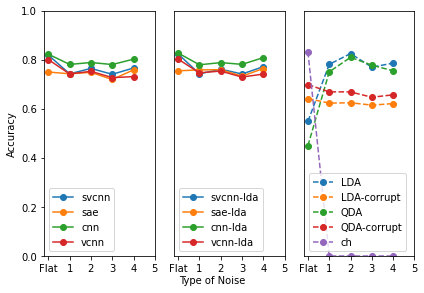

In [17]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    _ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(4,8):    
    ax[1].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(8,13):    
    ax[2].plot(np.hstack((flat_ave),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

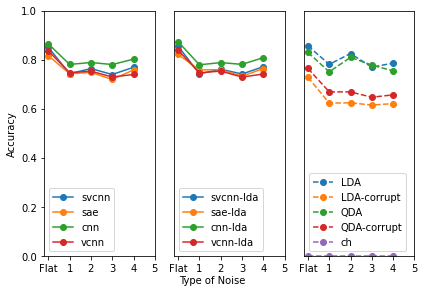

In [18]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(4,8):    
    ax[1].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(8,13):    
    ax[2].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

## Removing Noisy Channels Loop

In [5]:
test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
al = np.squeeze(test)

In [ ]:
# Index subject and training group
num_ch = int(n_type[-1]) + 1
full_type = n_type[0:4]
noise_type = n_type[4:-1]

# tile data once for each channel
if full_type == 'full':
    start_ch = 1
# tile data twice, once for clean and once for noise
elif full_type == 'part':
    start_ch = num_ch - 1

acc_all = np.zeros(num_ch-start_ch)
# loop through channel noise
for num_noise in range(start_ch,num_ch):
    ch_all = list(combinations(range(0,6),num_noise))
    ch_split = temp.shape[0]//len(ch_all)
    acc_ch = np.zeros(len(ch_all))
    for ch in range(0,len(ch_all)):
        temp = x[ch*ch_split:(ch+1)*ch_split,:,:]
        y_test = y[ch*ch_split:(ch+1)*ch_split,:]
        mask = np.ones(temp.shape[1],dtype=bool)
        for i in ch_all[ch]:
            mask[i] = 0
        maskmu = np.tile(mask,4)
        test_data = temp[:,mask,:]
        w_temp, c_temp = train_lda(test_data,label,mu_bool = True, mu[maskmu], mu_class[:,maskmu], C[maskmu,maskmu])
        acc_ch[ch] = eval_lda(w_temp, c_temp, test_data, y_test)
    acc_all[num_noise-start_ch] = np.mean(acc_ch)
    


## Latent Dimension Loop

In [ ]:
# loop through latent dimensions
sub_all, sub_noise, sub_clean, file_name = lp.loop_alldim(raw, params, sub_type, load=False, n_train='gaussflat', train_scale=3, n_test='gauss', test_scale=1,epochs=30, sparsity=True, dt='0414')

In [ ]:
# load results from latent dimension loop, sparse vs. not sparse
sub_all, sub_noise, sub_clean, sparse_all, sparse_noise, sparse_clean = lp.load_results(params, sub_type=sub_type,sparsity=True, dt='0414')
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.load_results(params, sub_type=sub_type,sparsity=False, dt='0414')

In [ ]:
# Plot accuracy vs. latent dimension
fig,ax = plt.subplots(1,2)
for i in range(0,4):
    ax[0].plot(ave_noise[:,i],'-o')
    ax[1].plot(sparse_noise[:,i],'-o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0.04, 'Latent Dimension', ha='center')
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0.5,1)
ax[0].legend(['svcnn','sae','cnn','vcnn'])